In [1]:
%cd ..
%pip install -e .

/home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
Obtaining file:///home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
  Preparing metadata (setup.py) ... done
  Attempting uninstall: src
    Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0
  Running setup.py develop for src
Note: you may need to restart the kernel to use updated packages.


In [7]:
import random

from src.models.dense import NN0
from src.models.dense import NN1
from src.models.gcn import GCN0

from src.models.train_model import train_with_loss
from src.models.train_model import random_splits

from src.models.reg import make_preg_loss

from src.models.reg import compute_a_hat

from src.models.evaluate_model import evaluate0
from src.models.evaluate_model import evaluate1

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from sklearn.manifold import TSNE

from src.models.evaluate_model import test

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=T.NormalizeFeatures())
# no normalization, using n != 0 and m!= 0 instead
# doesnt work, just use normalization instead

# try with no normalization, using n != 0 and m!= 0 
# dataset = Planetoid(root='data/Planetoid', name='Cora')


def set_reg_mask(data, A):
    reg_indeces = random.sample(range(data.x.shape[0]), k=A)
    reg_mask = torch.zeros(len(data.y), dtype=torch.bool)
    for i in reg_indeces:
        reg_mask[i] = True
    data.reg_mask = reg_mask
    return data


data = dataset[0].to(device)
data = random_splits(data, 50, 20)
# data = set_reg_mask(data, data.train_mask.shape[0])
data.reg_mask = torch.ones_like(data.train_mask, dtype=torch.bool)

L_cls = lambda x, y: F.nll_loss(torch.log(x), y, reduction='sum')
L_preg = lambda x, y: F.cross_entropy(x, y, reduction='sum')

A_hat = compute_a_hat(data)

print('-------------------------------------------------------------')
print(f'train size: {data.train_mask.sum()}')
print(f'valid size: {data.valid_mask.sum()}')
print(f'test size: {data.test_mask.sum()}')
print('-------------------------------------------------------------')


metrics = []

for mu in range(11):
    mu = mu / 10
    
    torch.manual_seed(1)
    random.seed(1)

    loss_fn = make_preg_loss(L_cls, L_preg, mu, A_hat)

    gcn_model = GCN0(num_node_features=dataset.num_node_features,
                     num_classes=dataset.num_classes) \
                    .to(device)

    gcn_model = train_with_loss(gcn_model, data, loss_fn, num_epochs=350)
    # gcn_model = train2(gcn_model, data)
    acc = evaluate0(gcn_model, data)
    # print(f'mu: {mu}, reg, Accuracy: {acc:.4f}')

    train_acc, val_acc, test_acc = evaluate1(gcn_model, data)
    metrics.append({'mu': mu, 'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc})
    print(f'mu: {mu}, train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}, test_acc: {test_acc:.4f}')
    print('-------------------------------------------------------------')
   


-------------------------------------------------------------
train size: 350
valid size: 140
test size: 2218
-------------------------------------------------------------
mu: 0.0, train_acc: 0.9943, val_acc: 0.8429, test_acc: 0.8354
-------------------------------------------------------------
mu: 0.05, train_acc: 0.9943, val_acc: 0.8429, test_acc: 0.8381
-------------------------------------------------------------


KeyboardInterrupt: 

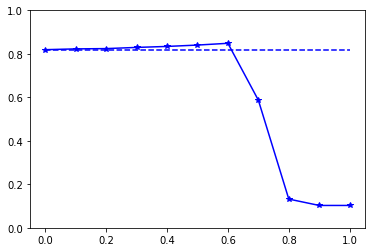

In [ ]:
import pandas as pd
import numpy as np


df = pd.DataFrame(metrics)
fig, ax = plt.subplots()
ax.plot(df['mu'], df['test_acc'], '-b*')
ax.plot(df['mu'], 11*[df['test_acc'][df['mu']==0]], '--b')
ax.set(ylim=(0, 1))
plt.show()

In [ ]:
L_preg = lambda x, y: F.cross_entropy(x, y)

x = torch.tensor([
    [0,1,1,1],
], dtype=torch.float32)

y = torch.tensor([
    [0,1,1,1],
], dtype=torch.float32)

L_preg(x, y)

tensor(3.6428)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=T.NormalizeFeatures())
# no normalization, using n != 0 and m!= 0 instead
# doesnt work, just use normalization instead

# try with no normalization, using n != 0 and m!= 0 
# dataset = Planetoid(root='data/Planetoid', name='Cora')


def set_reg_mask(data, A):
    reg_indeces = random.sample(range(data.x.shape[0]), k=A)
    reg_mask = torch.zeros(len(data.y), dtype=torch.bool)
    for i in reg_indeces:
        reg_mask[i] = True
    data.reg_mask = reg_mask
    return data


data = dataset[0].to(device)
data = random_splits(data, 50, 20)
# data = set_reg_mask(data, data.train_mask.shape[0])
data.reg_mask = torch.ones_like(data.train_mask, dtype=torch.bool)
L_cls = lambda x, y: F.cross_entropy(x, y, reduction='sum')
L_preg = lambda x, y: F.cross_entropy(x, y, reduction='sum')

A_hat = compute_a_hat(data)


print('-------------------------------------------------------------')
print(f'train size: {data.train_mask.sum()}')
print(f'valid size: {data.valid_mask.sum()}')
print(f'test size: {data.test_mask.sum()}')
print('-------------------------------------------------------------')


metrics = []

for mu in range(21):
    mu = mu / 10
    
    torch.manual_seed(1)
    random.seed(1)

    loss_fn = make_preg_loss(L_cls, L_preg, mu, A_hat)

    gcn_model = GCN0(num_node_features=dataset.num_node_features,
                     num_classes=dataset.num_classes) \
                    .to(device)

    gcn_model = train_with_loss(gcn_model, data, loss_fn, num_epochs=350)
    # gcn_model = train2(gcn_model, data)
    acc = evaluate0(gcn_model, data)
    # print(f'mu: {mu}, reg, Accuracy: {acc:.4f}')

    train_acc, val_acc, test_acc = evaluate1(gcn_model, data)
    metrics.append({'mu': mu, 'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc})
    print(f'mu: {mu}, train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}, test_acc: {test_acc:.4f}')
    print('-------------------------------------------------------------')
   


-------------------------------------------------------------
train size: 350
valid size: 140
test size: 2218
-------------------------------------------------------------
mu: 0.0, train_acc: 0.7000, val_acc: 0.6214, test_acc: 0.4892
-------------------------------------------------------------
mu: 0.1, train_acc: 0.5657, val_acc: 0.5071, test_acc: 0.4391
-------------------------------------------------------------
mu: 0.2, train_acc: 0.2800, val_acc: 0.2429, test_acc: 0.1614
-------------------------------------------------------------
mu: 0.3, train_acc: 0.1429, val_acc: 0.1429, test_acc: 0.1028
-------------------------------------------------------------
mu: 0.4, train_acc: 0.1429, val_acc: 0.1429, test_acc: 0.1028
-------------------------------------------------------------
mu: 0.5, train_acc: 0.1429, val_acc: 0.1429, test_acc: 0.1028
-------------------------------------------------------------
mu: 0.6, train_acc: 0.1429, val_acc: 0.1429, test_acc: 0.1028
----------------------

KeyboardInterrupt: 